In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

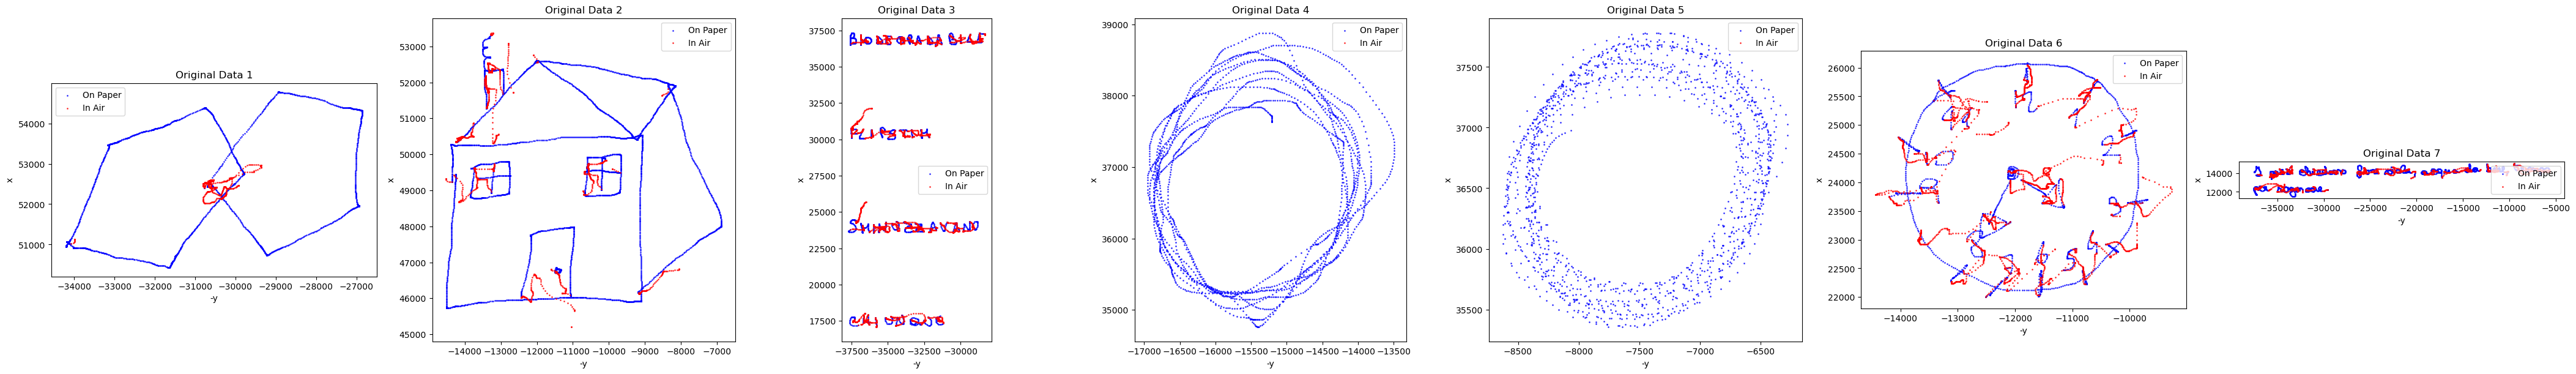

Number of processed files: 7
Average number of data points: 3616


In [35]:
# Cell 2
# Updated function
# Updated function without saving data inside
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []  # Processed data after scaling
    original_data_frames = []  # Save the original unscaled data
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        # Keep a copy of the original data before scaling
        original_data_frames.append(df.copy())  # Save the original unmodified data
        
        # Process the data for use in the model
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames  # Return original data

# Save data outside the function
def save_original_data(data_frames, input_filenames, output_folder='original_absolute'):
    os.makedirs(output_folder, exist_ok=True)
    for df, filename in zip(data_frames, input_filenames):
        save_path = os.path.join(output_folder, filename)
        df.to_csv(save_path, sep=' ', index=False, header=False)

directory = 'All'  # Directory where the .svc files are stored
num_files_to_use = 7
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)

# Save the original data after processing
save_original_data(original_data_frames, input_filenames)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


In [36]:
# Cell 6 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        config.pop('trainable', None)
        config.pop('dtype', None)
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'latent_dim': self.latent_dim
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 256
learning_rate = 0.001

vae = VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [37]:
# Cell 7 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        original_data = data_frames[i % num_input_files]
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()

        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

Epoch 1/100: 100%|██████████| 6/6 [00:10<00:00,  1.83s/batch, Generator Loss=0.61, Reconstruction Loss=0.608, KL Loss=0.00221] 


Epoch 1: Generator Loss = 0.658360, Reconstruction Loss = 0.656521, KL Divergence Loss = 0.001839


Epoch 2/100: 100%|██████████| 6/6 [00:00<00:00, 19.33batch/s, Generator Loss=0.616, Reconstruction Loss=0.613, KL Loss=0.00288]


Epoch 2: Generator Loss = 0.622206, Reconstruction Loss = 0.619602, KL Divergence Loss = 0.002604


Epoch 3/100: 100%|██████████| 6/6 [00:00<00:00, 19.32batch/s, Generator Loss=0.6, Reconstruction Loss=0.596, KL Loss=0.00459]  


Epoch 3: Generator Loss = 0.595481, Reconstruction Loss = 0.591734, KL Divergence Loss = 0.003747


Epoch 4/100: 100%|██████████| 6/6 [00:00<00:00,  8.94batch/s, Generator Loss=0.568, Reconstruction Loss=0.557, KL Loss=0.0109] 


Epoch 4: Generator Loss = 0.562804, Reconstruction Loss = 0.554921, KL Divergence Loss = 0.007882


Epoch 5/100: 100%|██████████| 6/6 [00:00<00:00, 20.71batch/s, Generator Loss=0.443, Reconstruction Loss=0.418, KL Loss=0.0258]


Epoch 5: Generator Loss = 0.489612, Reconstruction Loss = 0.470900, KL Divergence Loss = 0.018712


Epoch 6/100: 100%|██████████| 6/6 [00:00<00:00, 19.78batch/s, Generator Loss=0.321, Reconstruction Loss=0.27, KL Loss=0.051]  


Epoch 6: Generator Loss = 0.380831, Reconstruction Loss = 0.340761, KL Divergence Loss = 0.040070


Epoch 7/100: 100%|██████████| 6/6 [00:00<00:00, 20.10batch/s, Generator Loss=0.227, Reconstruction Loss=0.168, KL Loss=0.0581]


Epoch 7: Generator Loss = 0.276894, Reconstruction Loss = 0.220273, KL Divergence Loss = 0.056621


Epoch 8/100: 100%|██████████| 6/6 [00:00<00:00, 19.96batch/s, Generator Loss=0.181, Reconstruction Loss=0.112, KL Loss=0.0698]


Epoch 8: Generator Loss = 0.201237, Reconstruction Loss = 0.137536, KL Divergence Loss = 0.063700


Epoch 9/100: 100%|██████████| 6/6 [00:00<00:00, 19.68batch/s, Generator Loss=0.153, Reconstruction Loss=0.0952, KL Loss=0.0577]


Epoch 9: Generator Loss = 0.159843, Reconstruction Loss = 0.095504, KL Divergence Loss = 0.064339


Epoch 10/100: 100%|██████████| 6/6 [00:00<00:00, 19.67batch/s, Generator Loss=0.137, Reconstruction Loss=0.0898, KL Loss=0.0474]


Epoch 10: Generator Loss = 0.139041, Reconstruction Loss = 0.085640, KL Divergence Loss = 0.053401


Epoch 11/100: 100%|██████████| 6/6 [00:00<00:00, 20.32batch/s, Generator Loss=0.115, Reconstruction Loss=0.0781, KL Loss=0.0373]


Epoch 11: Generator Loss = 0.125104, Reconstruction Loss = 0.084387, KL Divergence Loss = 0.040717


Epoch 12/100: 100%|██████████| 6/6 [00:00<00:00,  9.78batch/s, Generator Loss=0.124, Reconstruction Loss=0.0918, KL Loss=0.0318]


Epoch 12: Generator Loss = 0.120203, Reconstruction Loss = 0.087061, KL Divergence Loss = 0.033142


Epoch 13/100: 100%|██████████| 6/6 [00:00<00:00, 16.49batch/s, Generator Loss=0.12, Reconstruction Loss=0.0878, KL Loss=0.032]  


Epoch 13: Generator Loss = 0.117846, Reconstruction Loss = 0.085663, KL Divergence Loss = 0.032184


Epoch 14/100: 100%|██████████| 6/6 [00:00<00:00, 19.73batch/s, Generator Loss=0.111, Reconstruction Loss=0.0801, KL Loss=0.0308]


Epoch 14: Generator Loss = 0.113119, Reconstruction Loss = 0.081190, KL Divergence Loss = 0.031929


Epoch 15/100: 100%|██████████| 6/6 [00:00<00:00, 21.64batch/s, Generator Loss=0.119, Reconstruction Loss=0.0854, KL Loss=0.0339]


Epoch 15: Generator Loss = 0.115237, Reconstruction Loss = 0.083381, KL Divergence Loss = 0.031856


Epoch 16/100: 100%|██████████| 6/6 [00:00<00:00, 17.99batch/s, Generator Loss=0.11, Reconstruction Loss=0.0785, KL Loss=0.0313] 


Epoch 16: Generator Loss = 0.111185, Reconstruction Loss = 0.077698, KL Divergence Loss = 0.033487


Epoch 17/100: 100%|██████████| 6/6 [00:00<00:00, 20.65batch/s, Generator Loss=0.106, Reconstruction Loss=0.0795, KL Loss=0.0267]


Epoch 17: Generator Loss = 0.109001, Reconstruction Loss = 0.080429, KL Divergence Loss = 0.028571


Epoch 18/100: 100%|██████████| 6/6 [00:00<00:00, 20.87batch/s, Generator Loss=0.104, Reconstruction Loss=0.0767, KL Loss=0.0278]


Epoch 18: Generator Loss = 0.110757, Reconstruction Loss = 0.083493, KL Divergence Loss = 0.027264


Epoch 19/100: 100%|██████████| 6/6 [00:00<00:00, 19.14batch/s, Generator Loss=0.123, Reconstruction Loss=0.0955, KL Loss=0.0275]


Epoch 19: Generator Loss = 0.109998, Reconstruction Loss = 0.081924, KL Divergence Loss = 0.028074


Epoch 20/100: 100%|██████████| 6/6 [00:00<00:00, 19.57batch/s, Generator Loss=0.104, Reconstruction Loss=0.0753, KL Loss=0.0283]


Epoch 20: Generator Loss = 0.107875, Reconstruction Loss = 0.080042, KL Divergence Loss = 0.027833


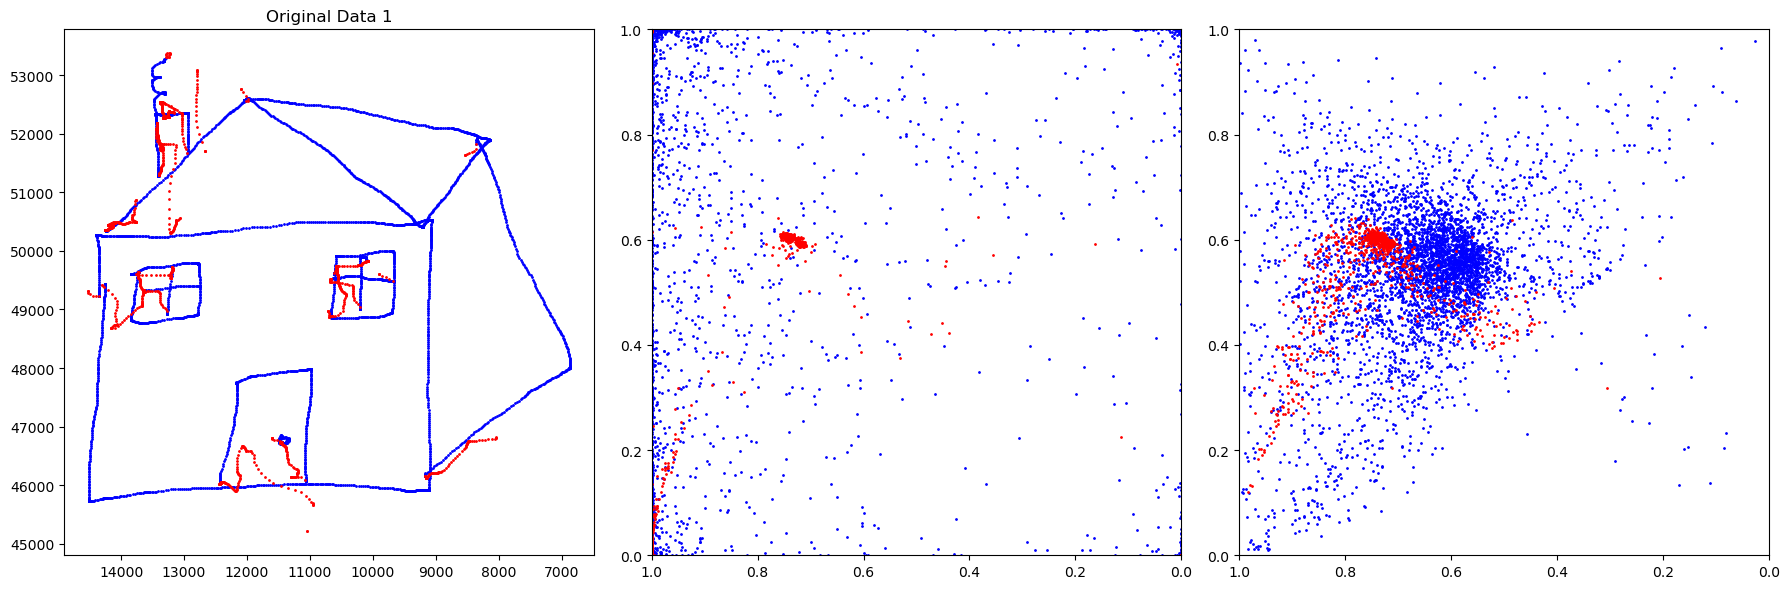

VAE model saved for epoch 20 at vae_models\epoch_20_model.h5.


Epoch 21/100: 100%|██████████| 6/6 [00:00<00:00, 18.52batch/s, Generator Loss=0.101, Reconstruction Loss=0.0744, KL Loss=0.027] 


Epoch 21: Generator Loss = 0.104795, Reconstruction Loss = 0.077652, KL Divergence Loss = 0.027143


Epoch 22/100: 100%|██████████| 6/6 [00:00<00:00, 13.79batch/s, Generator Loss=0.101, Reconstruction Loss=0.0758, KL Loss=0.0253]


Epoch 22: Generator Loss = 0.106897, Reconstruction Loss = 0.081120, KL Divergence Loss = 0.025777


Epoch 23/100: 100%|██████████| 6/6 [00:00<00:00, 14.07batch/s, Generator Loss=0.107, Reconstruction Loss=0.0805, KL Loss=0.0263]


Epoch 23: Generator Loss = 0.106158, Reconstruction Loss = 0.079559, KL Divergence Loss = 0.026599


Epoch 24/100: 100%|██████████| 6/6 [00:00<00:00, 17.60batch/s, Generator Loss=0.106, Reconstruction Loss=0.0793, KL Loss=0.0264]


Epoch 24: Generator Loss = 0.109191, Reconstruction Loss = 0.083088, KL Divergence Loss = 0.026103


Epoch 25/100: 100%|██████████| 6/6 [00:00<00:00,  9.37batch/s, Generator Loss=0.105, Reconstruction Loss=0.0751, KL Loss=0.03]  


Epoch 25: Generator Loss = 0.109175, Reconstruction Loss = 0.079669, KL Divergence Loss = 0.029506


Epoch 26/100: 100%|██████████| 6/6 [00:00<00:00, 14.33batch/s, Generator Loss=0.102, Reconstruction Loss=0.0726, KL Loss=0.029] 


Epoch 26: Generator Loss = 0.107016, Reconstruction Loss = 0.076917, KL Divergence Loss = 0.030099


Epoch 27/100: 100%|██████████| 6/6 [00:00<00:00, 13.71batch/s, Generator Loss=0.103, Reconstruction Loss=0.08, KL Loss=0.0235]  


Epoch 27: Generator Loss = 0.105142, Reconstruction Loss = 0.080023, KL Divergence Loss = 0.025119


Epoch 28/100: 100%|██████████| 6/6 [00:00<00:00, 14.00batch/s, Generator Loss=0.107, Reconstruction Loss=0.0816, KL Loss=0.0252]


Epoch 28: Generator Loss = 0.105526, Reconstruction Loss = 0.080963, KL Divergence Loss = 0.024563


Epoch 29/100: 100%|██████████| 6/6 [00:00<00:00, 15.67batch/s, Generator Loss=0.102, Reconstruction Loss=0.0753, KL Loss=0.0269]


Epoch 29: Generator Loss = 0.103736, Reconstruction Loss = 0.076765, KL Divergence Loss = 0.026971


Epoch 30/100: 100%|██████████| 6/6 [00:00<00:00, 12.15batch/s, Generator Loss=0.111, Reconstruction Loss=0.0855, KL Loss=0.0255]


Epoch 30: Generator Loss = 0.105059, Reconstruction Loss = 0.078634, KL Divergence Loss = 0.026426


Epoch 31/100: 100%|██████████| 6/6 [00:00<00:00, 20.14batch/s, Generator Loss=0.103, Reconstruction Loss=0.0765, KL Loss=0.0261]


Epoch 31: Generator Loss = 0.105467, Reconstruction Loss = 0.079205, KL Divergence Loss = 0.026262


Epoch 32/100: 100%|██████████| 6/6 [00:00<00:00, 17.38batch/s, Generator Loss=0.0989, Reconstruction Loss=0.0758, KL Loss=0.023]


Epoch 32: Generator Loss = 0.102252, Reconstruction Loss = 0.077395, KL Divergence Loss = 0.024858


Epoch 33/100: 100%|██████████| 6/6 [00:00<00:00, 10.66batch/s, Generator Loss=0.101, Reconstruction Loss=0.077, KL Loss=0.0244] 


Epoch 33: Generator Loss = 0.104828, Reconstruction Loss = 0.081330, KL Divergence Loss = 0.023498


Epoch 34/100: 100%|██████████| 6/6 [00:00<00:00, 12.45batch/s, Generator Loss=0.104, Reconstruction Loss=0.0794, KL Loss=0.0248] 


Epoch 34: Generator Loss = 0.103869, Reconstruction Loss = 0.078602, KL Divergence Loss = 0.025267


Epoch 35/100: 100%|██████████| 6/6 [00:00<00:00, 17.65batch/s, Generator Loss=0.114, Reconstruction Loss=0.0887, KL Loss=0.0255]


Epoch 35: Generator Loss = 0.103281, Reconstruction Loss = 0.078271, KL Divergence Loss = 0.025010


Epoch 36/100: 100%|██████████| 6/6 [00:00<00:00,  9.23batch/s, Generator Loss=0.102, Reconstruction Loss=0.0782, KL Loss=0.0242] 


Epoch 36: Generator Loss = 0.103897, Reconstruction Loss = 0.079062, KL Divergence Loss = 0.024835


Epoch 37/100: 100%|██████████| 6/6 [00:01<00:00,  4.52batch/s, Generator Loss=0.105, Reconstruction Loss=0.0821, KL Loss=0.0231] 


Epoch 37: Generator Loss = 0.102562, Reconstruction Loss = 0.078527, KL Divergence Loss = 0.024035


Epoch 38/100: 100%|██████████| 6/6 [00:00<00:00, 20.59batch/s, Generator Loss=0.101, Reconstruction Loss=0.0781, KL Loss=0.0232] 


Epoch 38: Generator Loss = 0.100542, Reconstruction Loss = 0.077090, KL Divergence Loss = 0.023452


Epoch 39/100: 100%|██████████| 6/6 [00:00<00:00,  7.75batch/s, Generator Loss=0.101, Reconstruction Loss=0.0745, KL Loss=0.026]  


Epoch 39: Generator Loss = 0.101408, Reconstruction Loss = 0.077302, KL Divergence Loss = 0.024107


Epoch 40/100: 100%|██████████| 6/6 [00:00<00:00,  6.74batch/s, Generator Loss=0.0994, Reconstruction Loss=0.075, KL Loss=0.0243]


Epoch 40: Generator Loss = 0.102706, Reconstruction Loss = 0.079112, KL Divergence Loss = 0.023595


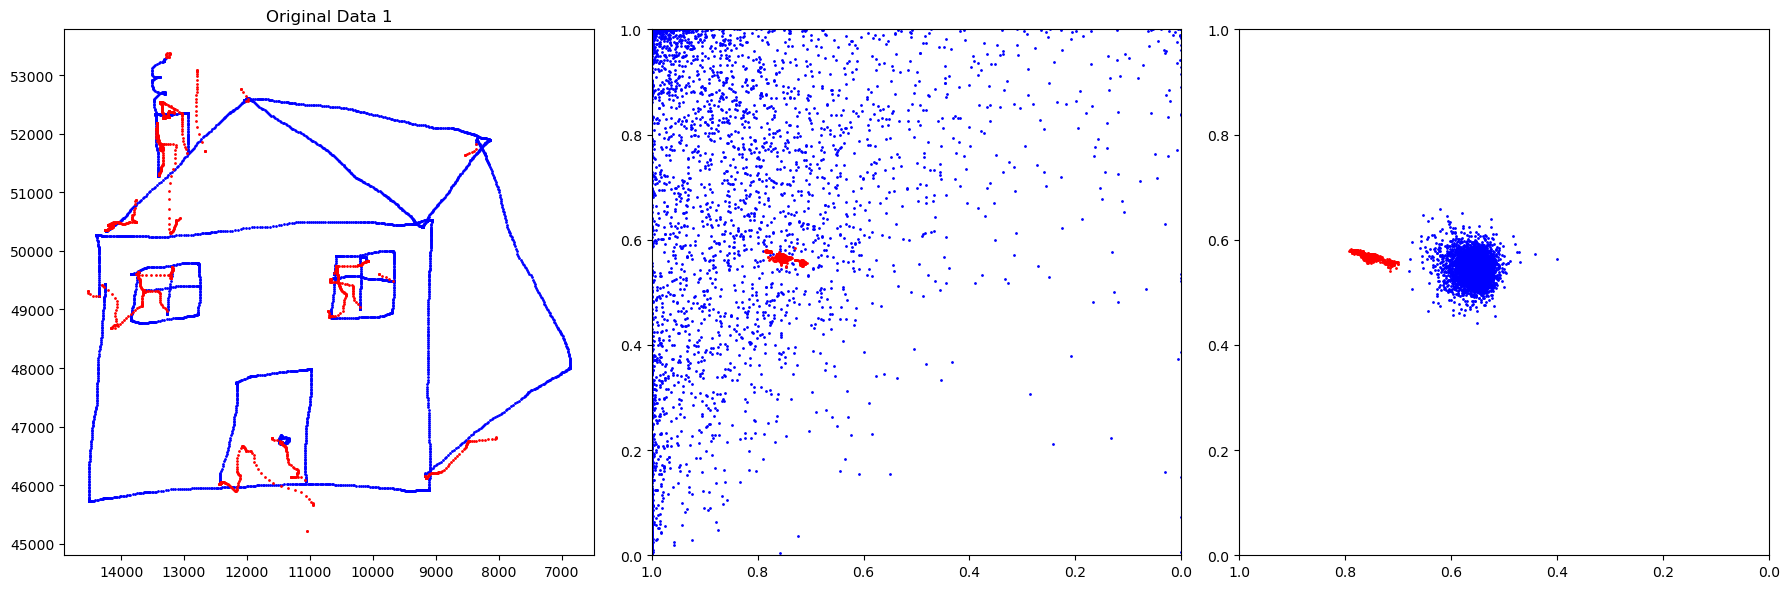

VAE model saved for epoch 40 at vae_models\epoch_40_model.h5.


Epoch 41/100: 100%|██████████| 6/6 [00:00<00:00, 17.71batch/s, Generator Loss=0.101, Reconstruction Loss=0.0742, KL Loss=0.0269]


Epoch 41: Generator Loss = 0.104953, Reconstruction Loss = 0.079498, KL Divergence Loss = 0.025455


Epoch 42/100: 100%|██████████| 6/6 [00:00<00:00, 17.34batch/s, Generator Loss=0.0993, Reconstruction Loss=0.073, KL Loss=0.0263] 


Epoch 42: Generator Loss = 0.102234, Reconstruction Loss = 0.075705, KL Divergence Loss = 0.026529


Epoch 43/100: 100%|██████████| 6/6 [00:00<00:00, 14.62batch/s, Generator Loss=0.102, Reconstruction Loss=0.0804, KL Loss=0.0216] 


Epoch 43: Generator Loss = 0.101713, Reconstruction Loss = 0.078141, KL Divergence Loss = 0.023573


Epoch 44/100: 100%|██████████| 6/6 [00:00<00:00, 16.40batch/s, Generator Loss=0.0994, Reconstruction Loss=0.0748, KL Loss=0.0246]


Epoch 44: Generator Loss = 0.107396, Reconstruction Loss = 0.085365, KL Divergence Loss = 0.022031


Epoch 45/100: 100%|██████████| 6/6 [00:00<00:00, 12.25batch/s, Generator Loss=0.102, Reconstruction Loss=0.0729, KL Loss=0.0286]


Epoch 45: Generator Loss = 0.104069, Reconstruction Loss = 0.075883, KL Divergence Loss = 0.028186


Epoch 46/100: 100%|██████████| 6/6 [00:00<00:00, 13.59batch/s, Generator Loss=0.0998, Reconstruction Loss=0.0754, KL Loss=0.0243]


Epoch 46: Generator Loss = 0.102530, Reconstruction Loss = 0.075502, KL Divergence Loss = 0.027028


Epoch 47/100: 100%|██████████| 6/6 [00:00<00:00, 15.16batch/s, Generator Loss=0.0975, Reconstruction Loss=0.0753, KL Loss=0.0223]


Epoch 47: Generator Loss = 0.103763, Reconstruction Loss = 0.080920, KL Divergence Loss = 0.022843


Epoch 48/100: 100%|██████████| 6/6 [00:00<00:00, 13.49batch/s, Generator Loss=0.101, Reconstruction Loss=0.0775, KL Loss=0.0233] 


Epoch 48: Generator Loss = 0.102339, Reconstruction Loss = 0.078916, KL Divergence Loss = 0.023423


Epoch 49/100: 100%|██████████| 6/6 [00:00<00:00,  6.36batch/s, Generator Loss=0.0988, Reconstruction Loss=0.0754, KL Loss=0.0233]


Epoch 49: Generator Loss = 0.101299, Reconstruction Loss = 0.077846, KL Divergence Loss = 0.023453


Epoch 50/100: 100%|██████████| 6/6 [00:00<00:00, 12.84batch/s, Generator Loss=0.0967, Reconstruction Loss=0.0746, KL Loss=0.0221]


Epoch 50: Generator Loss = 0.101936, Reconstruction Loss = 0.078890, KL Divergence Loss = 0.023046


Epoch 51/100: 100%|██████████| 6/6 [00:19<00:00,  3.17s/batch, Generator Loss=0.238, Reconstruction Loss=0.0737, KL Loss=0.0256]


LSTM training at epoch 51: Discriminator Loss = [1.3842821]
Epoch 51: Generator Loss = 0.241384, Reconstruction Loss = 0.078178, KL Divergence Loss = 0.024351


Epoch 52/100: 100%|██████████| 6/6 [00:00<00:00, 14.07batch/s, Generator Loss=0.107, Reconstruction Loss=0.0823, KL Loss=0.0245] 


Epoch 52: Generator Loss = 0.102510, Reconstruction Loss = 0.077671, KL Divergence Loss = 0.024839


Epoch 53/100: 100%|██████████| 6/6 [00:00<00:00, 11.25batch/s, Generator Loss=0.0985, Reconstruction Loss=0.0736, KL Loss=0.0249]


Epoch 53: Generator Loss = 0.100084, Reconstruction Loss = 0.074948, KL Divergence Loss = 0.025136


Epoch 54/100: 100%|██████████| 6/6 [00:00<00:00,  9.34batch/s, Generator Loss=0.0999, Reconstruction Loss=0.0753, KL Loss=0.0246]


Epoch 54: Generator Loss = 0.102284, Reconstruction Loss = 0.079795, KL Divergence Loss = 0.022489


Epoch 55/100: 100%|██████████| 6/6 [00:00<00:00, 14.11batch/s, Generator Loss=0.0962, Reconstruction Loss=0.0734, KL Loss=0.0229]


Epoch 55: Generator Loss = 0.100442, Reconstruction Loss = 0.077899, KL Divergence Loss = 0.022543


Epoch 56/100: 100%|██████████| 6/6 [00:00<00:00, 14.69batch/s, Generator Loss=0.104, Reconstruction Loss=0.0782, KL Loss=0.0256] 


Epoch 56: Generator Loss = 0.101002, Reconstruction Loss = 0.077405, KL Divergence Loss = 0.023596


Epoch 57/100: 100%|██████████| 6/6 [00:00<00:00, 11.11batch/s, Generator Loss=0.11, Reconstruction Loss=0.086, KL Loss=0.0243]   


Epoch 57: Generator Loss = 0.102924, Reconstruction Loss = 0.077771, KL Divergence Loss = 0.025153


Epoch 58/100: 100%|██████████| 6/6 [00:00<00:00,  7.47batch/s, Generator Loss=0.106, Reconstruction Loss=0.0827, KL Loss=0.0234] 


Epoch 58: Generator Loss = 0.101978, Reconstruction Loss = 0.077747, KL Divergence Loss = 0.024230


Epoch 59/100: 100%|██████████| 6/6 [00:00<00:00, 10.14batch/s, Generator Loss=0.101, Reconstruction Loss=0.0754, KL Loss=0.0257] 


Epoch 59: Generator Loss = 0.101511, Reconstruction Loss = 0.077463, KL Divergence Loss = 0.024048


Epoch 60/100: 100%|██████████| 6/6 [00:00<00:00, 12.71batch/s, Generator Loss=0.0973, Reconstruction Loss=0.0741, KL Loss=0.0232]


Epoch 60: Generator Loss = 0.101126, Reconstruction Loss = 0.076979, KL Divergence Loss = 0.024147


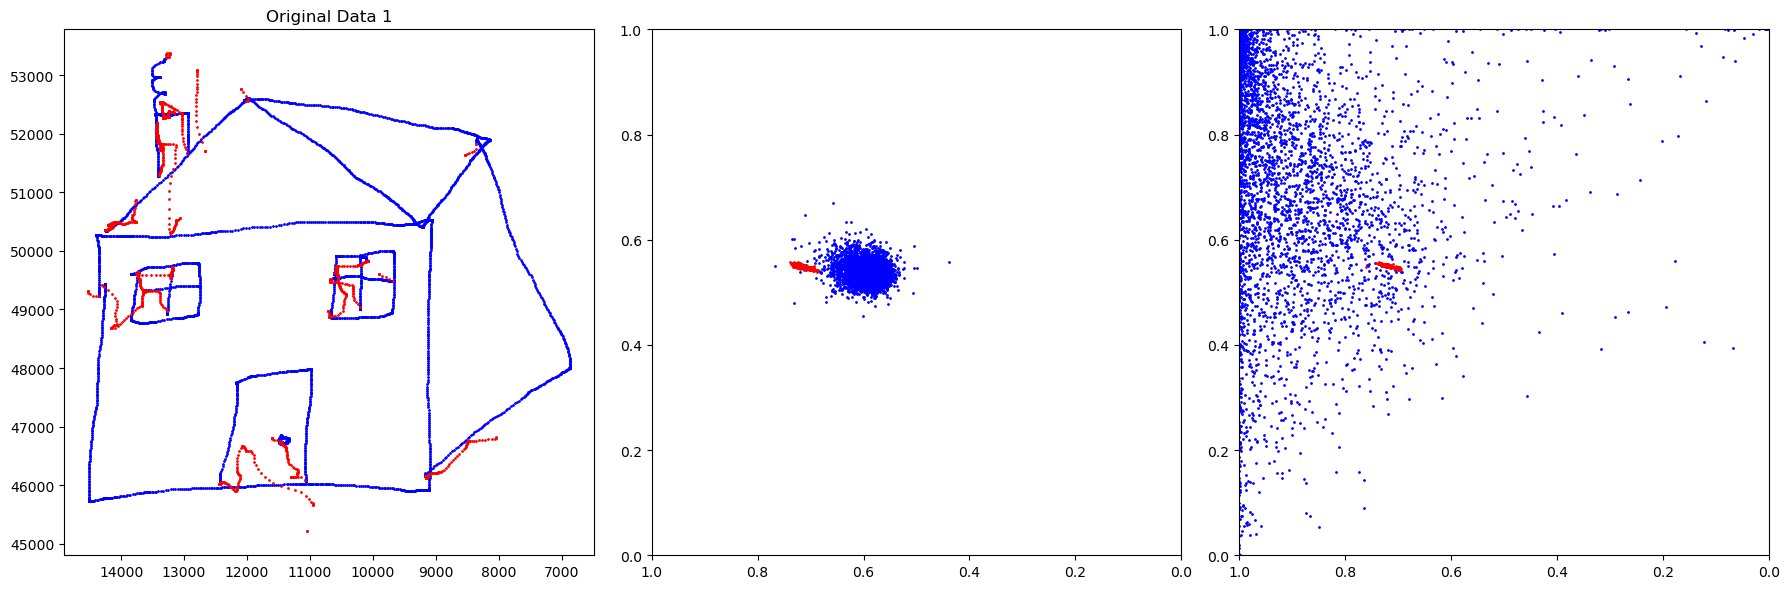

VAE model saved for epoch 60 at vae_models\epoch_60_model.h5.


Epoch 61/100: 100%|██████████| 6/6 [00:06<00:00,  1.05s/batch, Generator Loss=0.245, Reconstruction Loss=0.0841, KL Loss=0.0216]


LSTM training at epoch 61: Discriminator Loss = [1.3556187]
Epoch 61: Generator Loss = 0.238550, Reconstruction Loss = 0.077135, KL Divergence Loss = 0.022686


Epoch 62/100: 100%|██████████| 6/6 [00:00<00:00, 15.49batch/s, Generator Loss=0.0965, Reconstruction Loss=0.0703, KL Loss=0.0262]


Epoch 62: Generator Loss = 0.101829, Reconstruction Loss = 0.078189, KL Divergence Loss = 0.023640


Epoch 63/100: 100%|██████████| 6/6 [00:00<00:00, 14.99batch/s, Generator Loss=0.108, Reconstruction Loss=0.0844, KL Loss=0.0241] 


Epoch 63: Generator Loss = 0.102321, Reconstruction Loss = 0.076504, KL Divergence Loss = 0.025817


Epoch 64/100: 100%|██████████| 6/6 [00:00<00:00, 13.72batch/s, Generator Loss=0.104, Reconstruction Loss=0.0806, KL Loss=0.0236] 


Epoch 64: Generator Loss = 0.100678, Reconstruction Loss = 0.075235, KL Divergence Loss = 0.025443


Epoch 65/100: 100%|██████████| 6/6 [00:00<00:00, 16.61batch/s, Generator Loss=0.0954, Reconstruction Loss=0.0723, KL Loss=0.0231]


Epoch 65: Generator Loss = 0.100413, Reconstruction Loss = 0.076733, KL Divergence Loss = 0.023679


Epoch 66/100: 100%|██████████| 6/6 [00:00<00:00, 10.65batch/s, Generator Loss=0.111, Reconstruction Loss=0.0866, KL Loss=0.024]  


Epoch 66: Generator Loss = 0.101882, Reconstruction Loss = 0.078503, KL Divergence Loss = 0.023379


Epoch 67/100: 100%|██████████| 6/6 [00:00<00:00, 13.13batch/s, Generator Loss=0.0935, Reconstruction Loss=0.0687, KL Loss=0.0248]


Epoch 67: Generator Loss = 0.099306, Reconstruction Loss = 0.073964, KL Divergence Loss = 0.025342


Epoch 68/100: 100%|██████████| 6/6 [00:00<00:00, 13.98batch/s, Generator Loss=0.0985, Reconstruction Loss=0.0753, KL Loss=0.0232]


Epoch 68: Generator Loss = 0.099642, Reconstruction Loss = 0.075060, KL Divergence Loss = 0.024581


Epoch 69/100: 100%|██████████| 6/6 [00:00<00:00, 17.22batch/s, Generator Loss=0.101, Reconstruction Loss=0.0766, KL Loss=0.0242] 


Epoch 69: Generator Loss = 0.100107, Reconstruction Loss = 0.077283, KL Divergence Loss = 0.022823


Epoch 70/100: 100%|██████████| 6/6 [00:00<00:00, 14.93batch/s, Generator Loss=0.0932, Reconstruction Loss=0.0683, KL Loss=0.0249]


Epoch 70: Generator Loss = 0.100224, Reconstruction Loss = 0.075879, KL Divergence Loss = 0.024345


Epoch 71/100: 100%|██████████| 6/6 [00:04<00:00,  1.26batch/s, Generator Loss=0.236, Reconstruction Loss=0.0748, KL Loss=0.0224]


LSTM training at epoch 71: Discriminator Loss = [1.3402013]
Epoch 71: Generator Loss = 0.237358, Reconstruction Loss = 0.074023, KL Divergence Loss = 0.024891


Epoch 72/100: 100%|██████████| 6/6 [00:00<00:00, 19.13batch/s, Generator Loss=0.0911, Reconstruction Loss=0.069, KL Loss=0.0221] 


Epoch 72: Generator Loss = 0.097558, Reconstruction Loss = 0.074341, KL Divergence Loss = 0.023217


Epoch 73/100: 100%|██████████| 6/6 [00:00<00:00, 13.88batch/s, Generator Loss=0.102, Reconstruction Loss=0.0761, KL Loss=0.0258] 


Epoch 73: Generator Loss = 0.096821, Reconstruction Loss = 0.072288, KL Divergence Loss = 0.024532


Epoch 74/100: 100%|██████████| 6/6 [00:00<00:00, 16.47batch/s, Generator Loss=0.0956, Reconstruction Loss=0.0688, KL Loss=0.0268]


Epoch 74: Generator Loss = 0.095985, Reconstruction Loss = 0.070120, KL Divergence Loss = 0.025865


Epoch 75/100: 100%|██████████| 6/6 [00:00<00:00, 13.03batch/s, Generator Loss=0.0875, Reconstruction Loss=0.0628, KL Loss=0.0247]


Epoch 75: Generator Loss = 0.093276, Reconstruction Loss = 0.067532, KL Divergence Loss = 0.025744


Epoch 76/100: 100%|██████████| 6/6 [00:00<00:00, 15.09batch/s, Generator Loss=0.107, Reconstruction Loss=0.079, KL Loss=0.0277]  


Epoch 76: Generator Loss = 0.097897, Reconstruction Loss = 0.071841, KL Divergence Loss = 0.026057


Epoch 77/100: 100%|██████████| 6/6 [00:00<00:00, 15.50batch/s, Generator Loss=0.0932, Reconstruction Loss=0.0584, KL Loss=0.0348]


Epoch 77: Generator Loss = 0.093128, Reconstruction Loss = 0.061797, KL Divergence Loss = 0.031331


Epoch 78/100: 100%|██████████| 6/6 [00:00<00:00,  8.00batch/s, Generator Loss=0.0929, Reconstruction Loss=0.0647, KL Loss=0.0282]


Epoch 78: Generator Loss = 0.093479, Reconstruction Loss = 0.062937, KL Divergence Loss = 0.030543


Epoch 79/100: 100%|██████████| 6/6 [00:00<00:00, 15.33batch/s, Generator Loss=0.0994, Reconstruction Loss=0.07, KL Loss=0.0293]  


Epoch 79: Generator Loss = 0.095350, Reconstruction Loss = 0.066952, KL Divergence Loss = 0.028398


Epoch 80/100: 100%|██████████| 6/6 [00:00<00:00, 14.94batch/s, Generator Loss=0.0927, Reconstruction Loss=0.0609, KL Loss=0.0318]


Epoch 80: Generator Loss = 0.095527, Reconstruction Loss = 0.064600, KL Divergence Loss = 0.030926


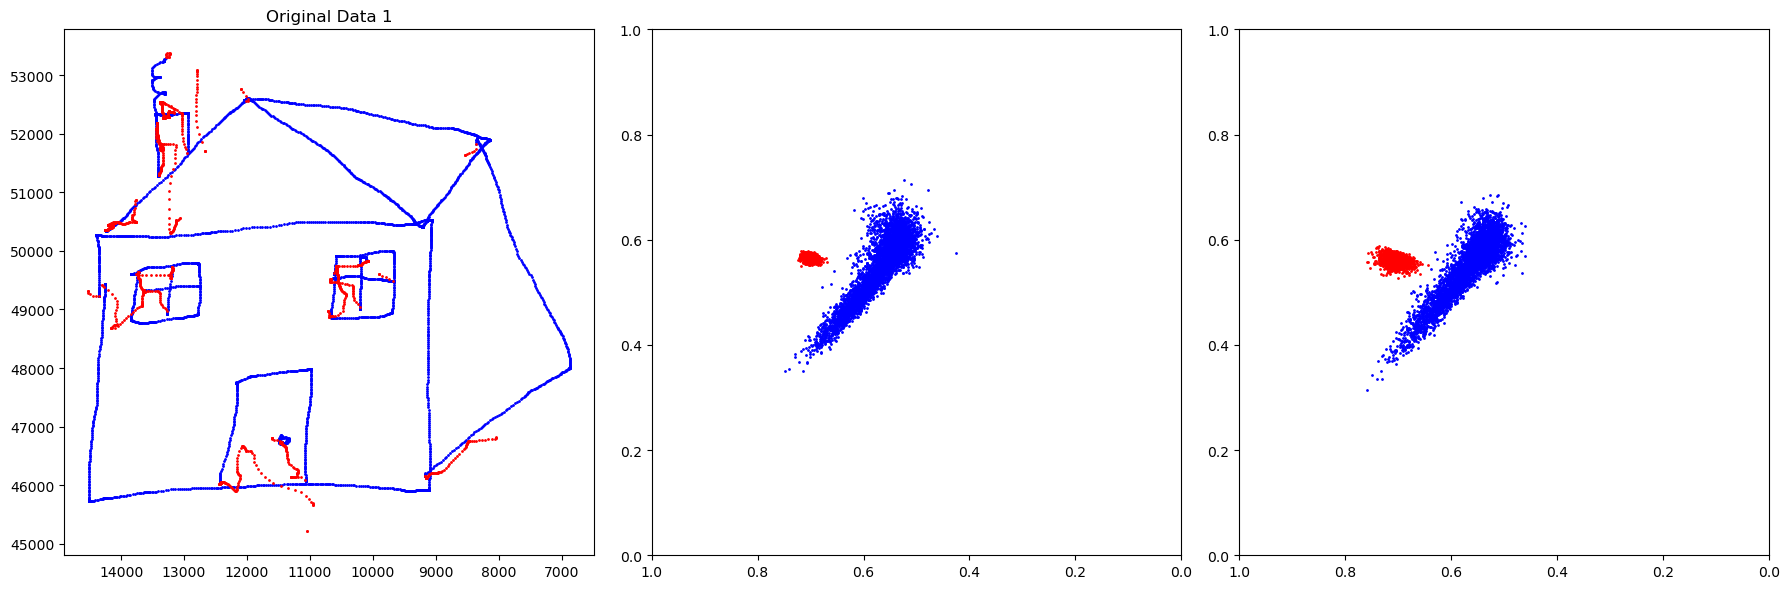

VAE model saved for epoch 80 at vae_models\epoch_80_model.h5.


Epoch 81/100: 100%|██████████| 6/6 [00:05<00:00,  1.12batch/s, Generator Loss=0.231, Reconstruction Loss=0.065, KL Loss=0.028]  


LSTM training at epoch 81: Discriminator Loss = [1.3223283]
Epoch 81: Generator Loss = 0.229821, Reconstruction Loss = 0.060824, KL Divergence Loss = 0.030608


Epoch 82/100: 100%|██████████| 6/6 [00:00<00:00,  9.29batch/s, Generator Loss=0.0927, Reconstruction Loss=0.063, KL Loss=0.0297] 


Epoch 82: Generator Loss = 0.091854, Reconstruction Loss = 0.062911, KL Divergence Loss = 0.028943


Epoch 83/100: 100%|██████████| 6/6 [00:00<00:00, 12.27batch/s, Generator Loss=0.0866, Reconstruction Loss=0.0565, KL Loss=0.0301]


Epoch 83: Generator Loss = 0.089944, Reconstruction Loss = 0.060090, KL Divergence Loss = 0.029854


Epoch 84/100: 100%|██████████| 6/6 [00:00<00:00, 13.47batch/s, Generator Loss=0.0956, Reconstruction Loss=0.0627, KL Loss=0.0329]


Epoch 84: Generator Loss = 0.092406, Reconstruction Loss = 0.061151, KL Divergence Loss = 0.031255


Epoch 85/100: 100%|██████████| 6/6 [00:00<00:00, 12.99batch/s, Generator Loss=0.0806, Reconstruction Loss=0.0521, KL Loss=0.0284]


Epoch 85: Generator Loss = 0.087217, Reconstruction Loss = 0.055140, KL Divergence Loss = 0.032076


Epoch 86/100: 100%|██████████| 6/6 [00:00<00:00, 13.28batch/s, Generator Loss=0.0838, Reconstruction Loss=0.0561, KL Loss=0.0277]


Epoch 86: Generator Loss = 0.086748, Reconstruction Loss = 0.058355, KL Divergence Loss = 0.028393


Epoch 87/100: 100%|██████████| 6/6 [00:00<00:00, 16.32batch/s, Generator Loss=0.0895, Reconstruction Loss=0.0595, KL Loss=0.03]  


Epoch 87: Generator Loss = 0.088373, Reconstruction Loss = 0.059810, KL Divergence Loss = 0.028562


Epoch 88/100: 100%|██████████| 6/6 [00:00<00:00, 13.14batch/s, Generator Loss=0.0827, Reconstruction Loss=0.0509, KL Loss=0.0318]


Epoch 88: Generator Loss = 0.085413, Reconstruction Loss = 0.053543, KL Divergence Loss = 0.031871


Epoch 89/100: 100%|██████████| 6/6 [00:00<00:00, 13.87batch/s, Generator Loss=0.0879, Reconstruction Loss=0.0551, KL Loss=0.0328]


Epoch 89: Generator Loss = 0.090072, Reconstruction Loss = 0.059130, KL Divergence Loss = 0.030942


Epoch 90/100: 100%|██████████| 6/6 [00:00<00:00, 11.51batch/s, Generator Loss=0.0816, Reconstruction Loss=0.0506, KL Loss=0.031] 


Epoch 90: Generator Loss = 0.088298, Reconstruction Loss = 0.057734, KL Divergence Loss = 0.030564


Epoch 91/100: 100%|██████████| 6/6 [00:04<00:00,  1.21batch/s, Generator Loss=0.219, Reconstruction Loss=0.051, KL Loss=0.03]   


LSTM training at epoch 91: Discriminator Loss = [1.2823699]
Epoch 91: Generator Loss = 0.224359, Reconstruction Loss = 0.055622, KL Divergence Loss = 0.030478


Epoch 92/100: 100%|██████████| 6/6 [00:00<00:00, 12.96batch/s, Generator Loss=0.0924, Reconstruction Loss=0.0626, KL Loss=0.0298]


Epoch 92: Generator Loss = 0.088440, Reconstruction Loss = 0.057490, KL Divergence Loss = 0.030950


Epoch 93/100: 100%|██████████| 6/6 [00:00<00:00, 14.43batch/s, Generator Loss=0.0829, Reconstruction Loss=0.0509, KL Loss=0.032] 


Epoch 93: Generator Loss = 0.087594, Reconstruction Loss = 0.056311, KL Divergence Loss = 0.031283


Epoch 94/100: 100%|██████████| 6/6 [00:00<00:00, 18.80batch/s, Generator Loss=0.0829, Reconstruction Loss=0.0519, KL Loss=0.031] 


Epoch 94: Generator Loss = 0.084375, Reconstruction Loss = 0.052327, KL Divergence Loss = 0.032048


Epoch 95/100: 100%|██████████| 6/6 [00:00<00:00, 17.22batch/s, Generator Loss=0.0831, Reconstruction Loss=0.0515, KL Loss=0.0316]


Epoch 95: Generator Loss = 0.085426, Reconstruction Loss = 0.054533, KL Divergence Loss = 0.030893


Epoch 96/100: 100%|██████████| 6/6 [00:00<00:00, 11.98batch/s, Generator Loss=0.0801, Reconstruction Loss=0.0508, KL Loss=0.0292]


Epoch 96: Generator Loss = 0.081952, Reconstruction Loss = 0.052201, KL Divergence Loss = 0.029751


Epoch 97/100: 100%|██████████| 6/6 [00:00<00:00, 14.23batch/s, Generator Loss=0.0852, Reconstruction Loss=0.053, KL Loss=0.0322] 


Epoch 97: Generator Loss = 0.085235, Reconstruction Loss = 0.054291, KL Divergence Loss = 0.030943


Epoch 98/100: 100%|██████████| 6/6 [00:00<00:00, 14.03batch/s, Generator Loss=0.0999, Reconstruction Loss=0.0685, KL Loss=0.0314]


Epoch 98: Generator Loss = 0.087412, Reconstruction Loss = 0.055163, KL Divergence Loss = 0.032249


Epoch 99/100: 100%|██████████| 6/6 [00:00<00:00, 11.54batch/s, Generator Loss=0.0809, Reconstruction Loss=0.0516, KL Loss=0.0293]


Epoch 99: Generator Loss = 0.082026, Reconstruction Loss = 0.050979, KL Divergence Loss = 0.031047


Epoch 100/100: 100%|██████████| 6/6 [00:00<00:00, 14.51batch/s, Generator Loss=0.0821, Reconstruction Loss=0.0502, KL Loss=0.0319]


Epoch 100: Generator Loss = 0.084057, Reconstruction Loss = 0.053298, KL Divergence Loss = 0.030760


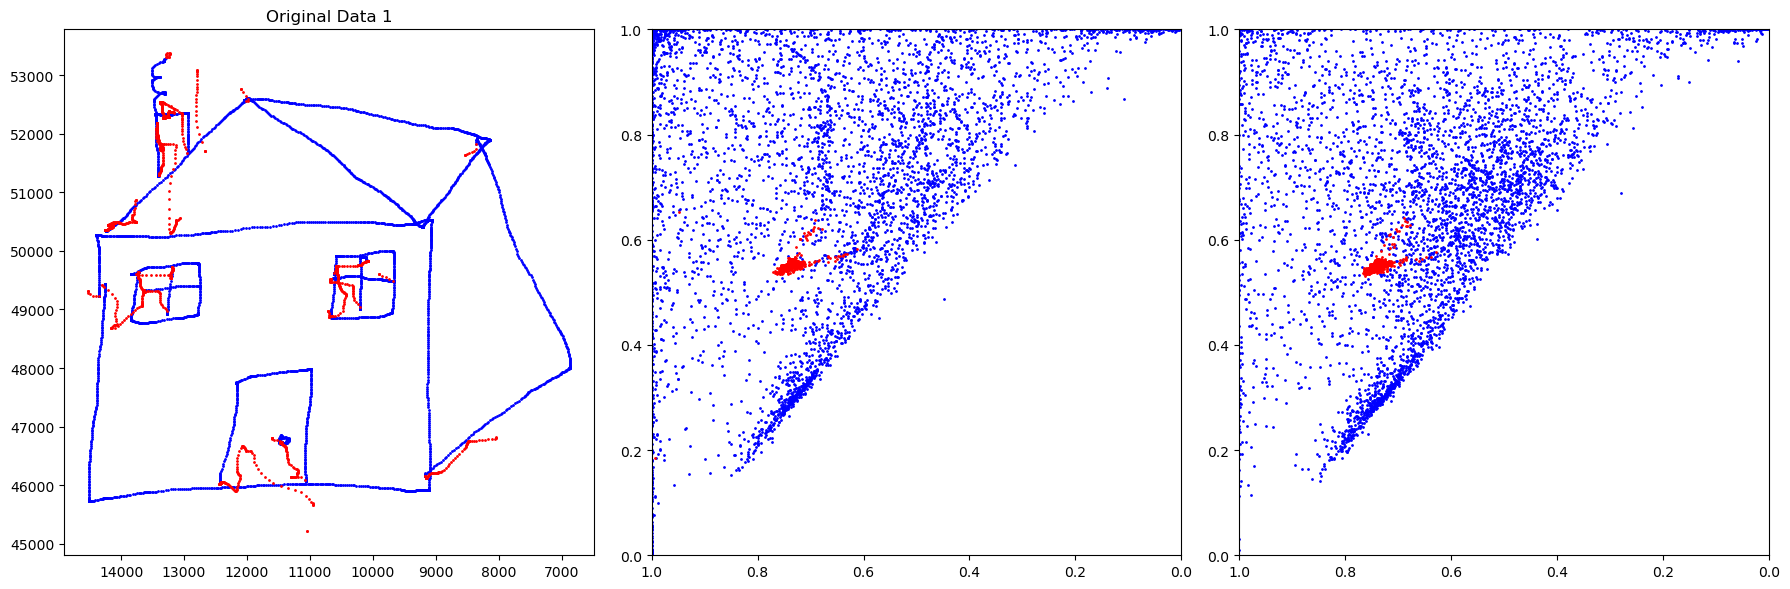

VAE model saved for epoch 100 at vae_models\epoch_100_model.h5.
Final VAE model saved.


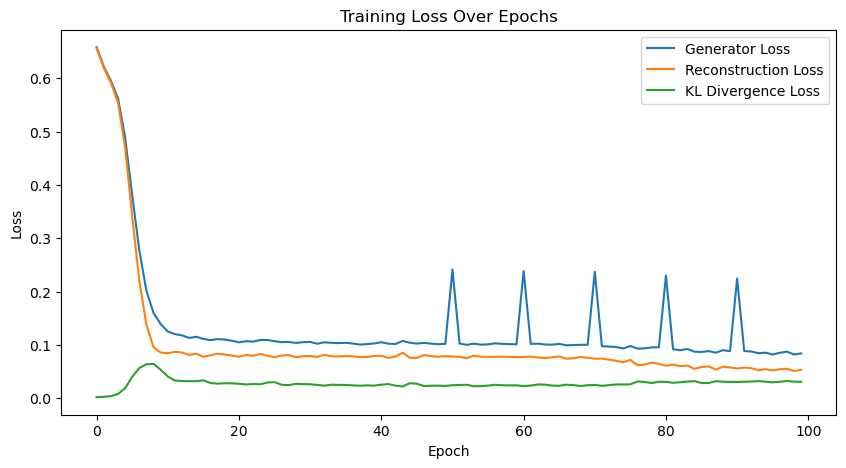

<Figure size 640x480 with 0 Axes>

In [33]:
#Cell 8
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + model.beta * total_kl_loss + 0.1 * discriminator_loss
        else:
            generator_loss = reconstruction_loss + model.beta * total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 1024
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 100
lstm_interval = 10
epochs = 200
visual_per_num_epoch = 20
num_augmented_files = 2

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

save_dir = "vae_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train LSTM every `lstm_interval` epochs after `vae_epochs`
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)
            generated_data = tf.expand_dims(augmented_data, axis=0)
            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')


    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)



    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")



    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)

        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6*(num_augmented_files + len(original_data_frames)), 6))

        for i, original_data in enumerate(original_data_frames):
            original_on_paper = original_data[original_data['pen_status'] == 1]
            original_in_air = original_data[original_data['pen_status'] == 0]

            axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].invert_xaxis()

        # Set consistent axis limits for square aspect ratio for both original and augmented data
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]

            axs[i+len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')
            axs[i+len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')
            axs[i+len(original_data_frames)].invert_xaxis()
            axs[i+len(original_data_frames)].set_xlim(y_max, y_min)
            axs[i+len(original_data_frames)].set_ylim(x_min, x_max)

        plt.tight_layout()
        plt.show()
        # Save VAE model after each epoch, directly into the `vae_models` folder
        model_save_path = os.path.join(save_dir, f"epoch_{epoch+1}_model.h5")
        vae.save(model_save_path)
        print(f"VAE model saved for epoch {epoch+1} at {model_save_path}.")

# Final output and plots
plt.ioff()
plt.show()

vae.save('pentab_saved_model.h5')
print("Final VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()